<a href="https://colab.research.google.com/github/Lucius-40/Computer-Vision-Projects/blob/main/CIFAR-10/Object_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Will try to classify objects from the cifar-10 dataset

In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

# Check GPU availability
torch.cuda.is_available()


True

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


Using device: cuda
GPU name: Tesla T4


Define the transformation :

In [67]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

Loading the dataset :

In [68]:
train_set = torchvision.datasets.CIFAR10(root='.', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='.', train=False , download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)
test_loader = DataLoader(test_set, batch_size=50, shuffle=False)

im, lab = train_set[0]

print(im.shape)
print(len(train_set))

torch.Size([3, 32, 32])
50000


Looking at random samples of teh dataset :

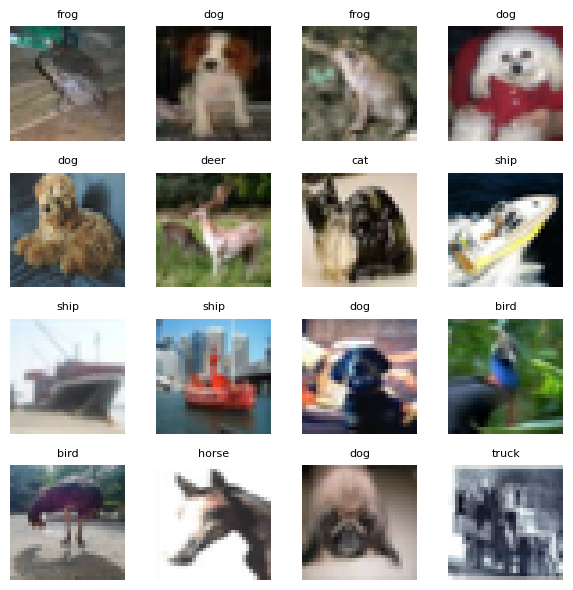

In [69]:

# Unnormalize
def unnormalize(img):
    img = img / 2 + 0.5
    return img.numpy()

# Get 16 random images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:16]

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    img = unnormalize(images[i])
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img)
    ax.set_title(train_set.classes[labels[i]], fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()




Simple CNN initially for a baseline level of accuracy :

In [70]:
class CNN_simple(nn.Module):
    def __init__(self):
        super(CNN_simple,self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4)
        self.dense1 = nn.Linear(3 * 3* 256, 250)
        self.output = nn.Linear(250,10)

    def forward(self, X):
        X = self.pool(torch.relu(self.conv1(X)))
        X = self.pool(torch.relu(self.conv2(X)))
        X = torch.relu(self.conv3(X))
        X = X.view(X.size(0),-1 )
        X = torch.relu(self.dense1(X))
        X = self.output(X)
        return X


model1 = CNN_simple().to(device)

Optimizers and loss function

In [71]:
optimizer = optim.SGD(
    model1.parameters(),
    lr=0.01,          # start here, adjust later
    momentum=0.9,     # helps accelerate in relevant directions
    weight_decay=1e-3 # L2 regularization
)

criterion = nn.CrossEntropyLoss()


Training loop :

In [72]:
for epoch in range(10):
    model1.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")


Epoch 1, Loss: 1.5895, Acc: 41.57%
Epoch 2, Loss: 1.1136, Acc: 60.11%
Epoch 3, Loss: 0.8835, Acc: 69.03%
Epoch 4, Loss: 0.7346, Acc: 74.18%
Epoch 5, Loss: 0.6280, Acc: 77.95%
Epoch 6, Loss: 0.5412, Acc: 81.00%
Epoch 7, Loss: 0.4614, Acc: 83.85%
Epoch 8, Loss: 0.3948, Acc: 86.21%
Epoch 9, Loss: 0.3339, Acc: 88.46%
Epoch 10, Loss: 0.2755, Acc: 90.45%


Evaluating the basic model :

In [73]:
model1.eval() # evaluation mode , no changes to the model
total = 0
correct = 0
wrong = 0
correct2 = 0
total2 = 0
with torch.no_grad():
    for images , labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs,1) # in axis 1 (columns), we look for the highest value in tensor, stores index of the max
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
    for images , labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs,1) # in axis 1 (columns), we look for the highest value in tensor, stores index of the max
        total2 += labels.size(0)
        correct2 += (labels == predicted).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")
print(f"Train Accuracy: {100 * correct2 / total2:.2f}%")
print("Total train : ",total2 )
print("Total test :", total)

Test Accuracy: 76.70%
Train Accuracy: 94.63%
Total train :  50000
Total test : 10000


So, for our basic model , we got a lot of overfitting , it does really well on the training set , but not onthe test set

**Proposed improvements for improvement of accuracy  :**

1.Introducing batch normalization to the simple network

In [82]:
class CNN_with_bn(nn.Module):
    def __init__(self):
        super(CNN_with_bn,self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.dense1 = nn.Linear(3 * 3* 256, 250)
        self.batchnorm4 = nn.BatchNorm1d(250)
        self.output = nn.Linear(250,10)

    def forward(self, X):
        X = self.pool(torch.relu(self.batchnorm1(self.conv1(X))))
        X = self.pool(torch.relu(self.batchnorm2(self.conv2(X))))
        X = torch.relu(self.batchnorm3(self.conv3(X)))
        X = X.view(X.size(0),-1 )
        X = torch.relu(self.batchnorm4(self.dense1(X)))
        X = self.output(X)
        return X

model2 = CNN_with_bn().to(device)

In [83]:
optimizer_bn = optim.SGD(
    model2.parameters(),
    lr=0.01,          # start here, adjust later
    momentum=0.9,     # helps accelerate in relevant directions
    weight_decay=1e-3 # L2 regularization
)

criterion_bn = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(15):
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer_bn.zero_grad()
        outputs = model2(images)
        loss = criterion_bn(outputs, labels)
        loss.backward()
        optimizer_bn.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")



Epoch 1, Loss: 1.1759, Acc: 58.03%


In [ ]:
model2.eval() # evaluation mode , no changes to the model
total = 0
correct = 0
wrong = 0
correct2 = 0
total2 = 0
with torch.no_grad():
    for images , labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs,1) # in axis 1 (columns), we look for the highest value in tensor, stores index of the max
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
    for images , labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs,1) # in axis 1 (columns), we look for the highest value in tensor, stores index of the max
        total2 += labels.size(0)
        correct2 += (labels == predicted).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")
print(f"Train Accuracy: {100 * correct2 / total2:.2f}%")
print("Total train : ",total2 )
print("Total test :", total)

*So we got the test accuracy to increase by 2 % . It is always a goo d idea to add more training data is there is a high variance. So we will do just that *

Improvememts :

1. Batch normalization(done)

2. Data Augmentation
